For this project, I will be examining the Heart Disease dataset from the UCI Machine Learning Repository.  I will be looking for patterns in what causes people to get heart disease.  To do this, I will be using the Python libraries of Pandas, Numpy, MatPlotLib, and Seaborn.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

dataset_path = '/Users/micah.isser/Downloads/heart_disease_uci.csv'
df = pd.read_csv(dataset_path)

print(df.head())

print(f"The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4             normal    0  
The data

According to the source on Kaggle, the columns mean the following:     
id (Unique id for each patient)
age (Age of the patient in years)
origin (place of study)
sex (Male/Female)
cp chest pain type ([typical angina, atypical angina, non-anginal, asymptomatic])
trestbps resting blood pressure (resting blood pressure (in mm Hg on admission to the hospital))
chol (serum cholesterol in mg/dl)
fbs (if fasting blood sugar > 120 mg/dl)
restecg (resting electrocardiographic results)
-- Values: [normal, stt abnormality, lv hypertrophy]
thalach: maximum heart rate achieved
exang: exercise-induced angina (True/ False)
oldpeak: ST depression induced by exercise relative to rest
slope: the slope of the peak exercise ST segment
ca: number of major vessels (0-3) colored by fluoroscopy
thal: [normal; fixed defect; reversible defect]
num: the predicted attribute

Now I will use the describe function to find out more about the data

In [3]:
df.describe()

,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


And let's find if there are missing values

In [4]:
df.isnull().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

Okay, so it looks like each of the 920 entries have an id, age, sex, and type of chest pain, but many are missing fluroscopy results or the type of heart defect.  Now let's start plotting with some univariate analysis.

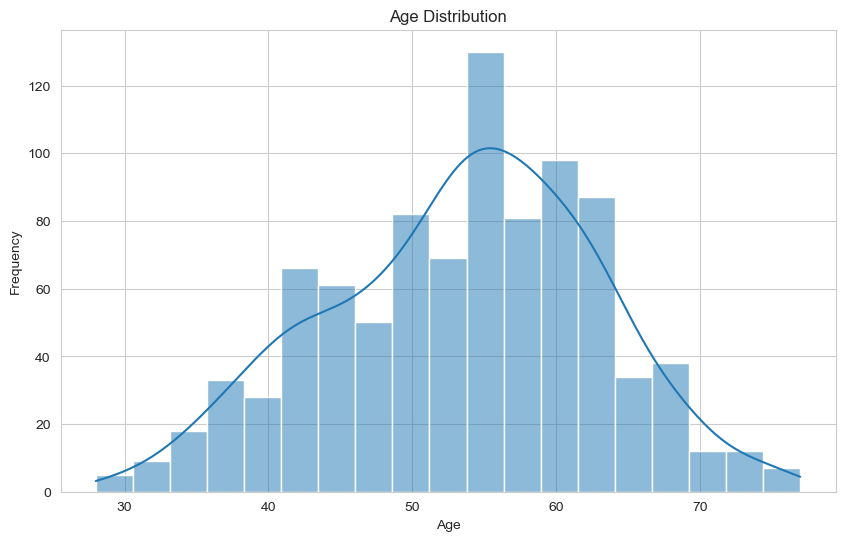

In [2]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', kde=True)  
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

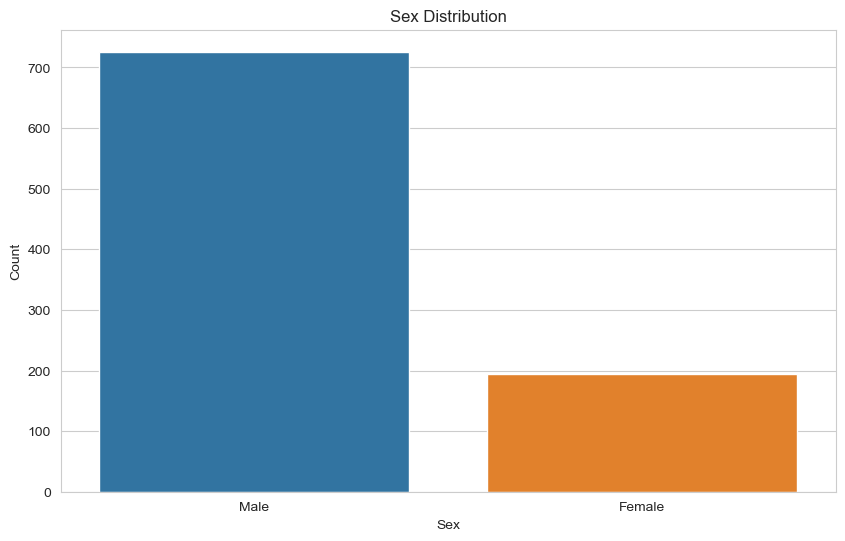

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sex')
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

I'm curious about how these variables might relate to one another, so I am going to graph them in a Correlation Matrix, using a cool/warm color scheme to indicate correlation.

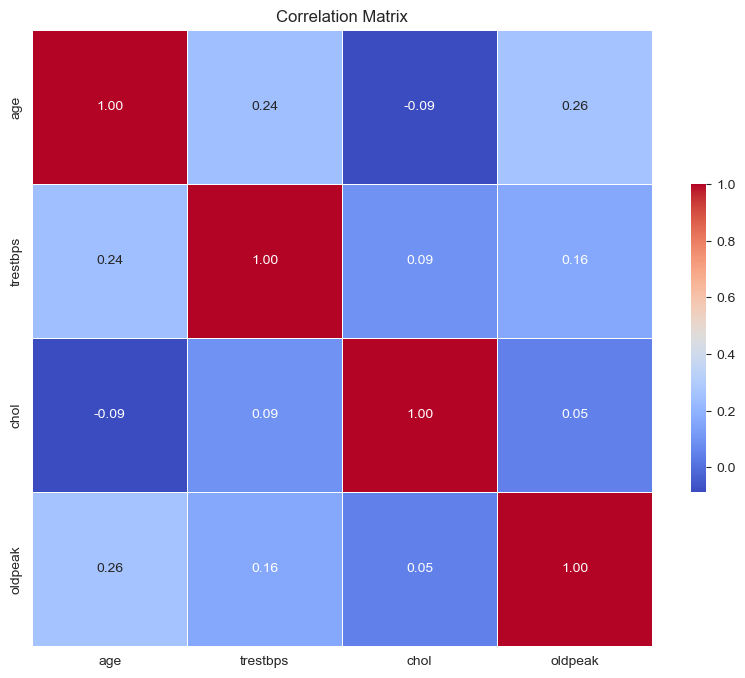

In [14]:
selected_columns = df.iloc[:, [1, 5, 6, 11]]
corr_matrix = selected_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", 
            linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix')
plt.show()

I notice an interesting corelation between age and oldpeak (the heart's response to exercise) - I'll plot the data points on a scatter plot to see the pattern between them.

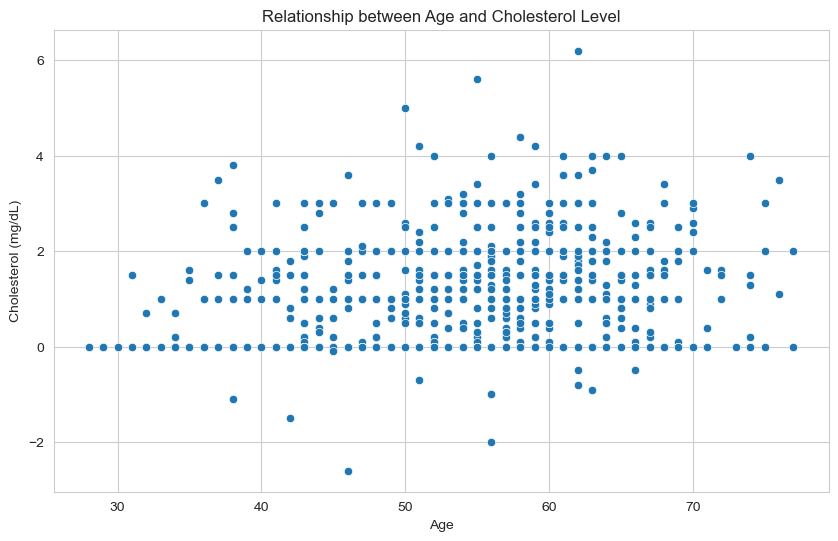

In [3]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='age', y='oldpeak')

plt.title('Relationship between Age and Cholesterol Level')
plt.xlabel('Age')
plt.ylabel('Cholesterol (mg/dL)')


plt.show()

Although this is the highest correlation in the correlation matrix, it still isn't particularly strong when graphed this way.  Since there are no clear linear relationships, I'll try using polynomial regression to find a non-linear relationship in the data.  When I initially tried to run the Linear Regression, it failed because of the Na values, so I'l use scikit's imputer method to replace Na values with the mean. 

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

X = df[['trestbps', 'chol', 'oldpeak']]
y = df['age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('poly_features', PolynomialFeatures(degree=2))
])

X_train_poly = pipeline.fit_transform(X_train)
X_test_poly = pipeline.transform(X_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)

y_pred = model.predict(X_test_poly)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 93.41773070810537


Now I've run a polynomial regression to try to use age as a predictor in the liklihood of heart attacks.  The Mean Squared Error shows how accurate this regression is.  Below, I'll graph how accurately the age-based regression could be used to account for heart attacks   

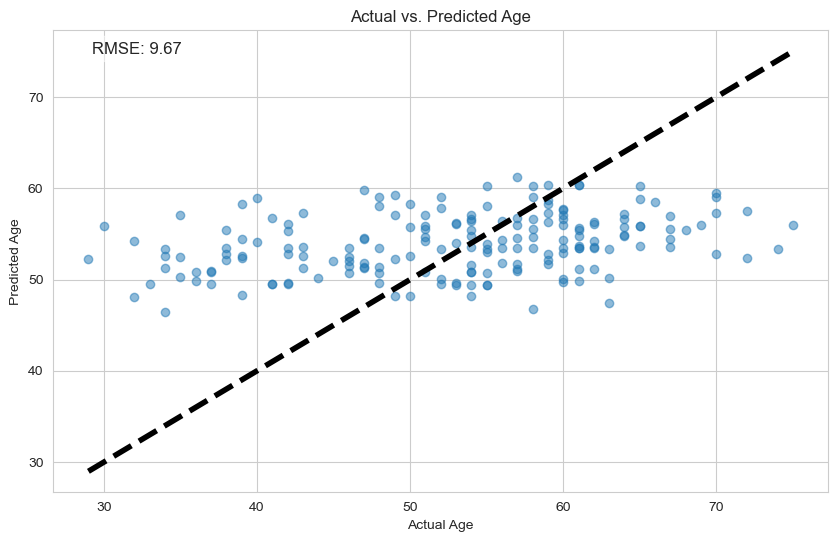

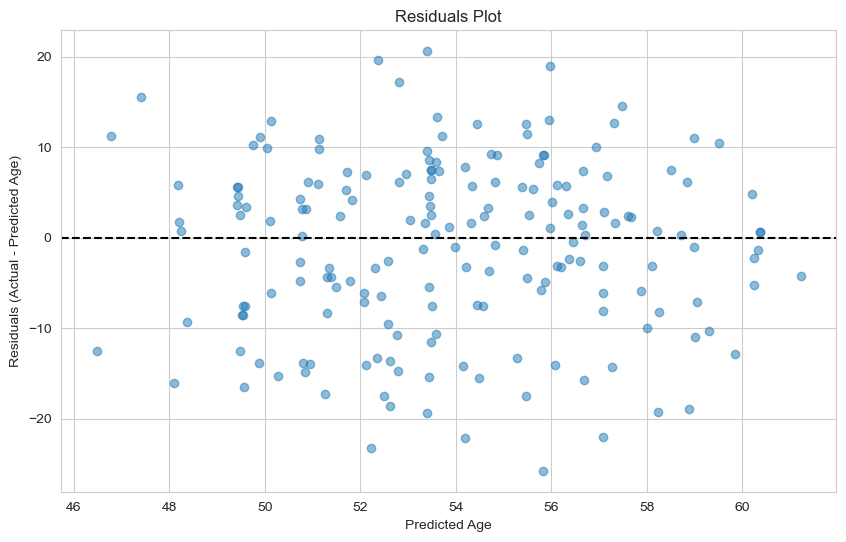

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line for perfect predictions
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Actual vs. Predicted Age')

rmse = np.sqrt(mse)

plt.annotate(f'RMSE: {rmse:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12,
             bbox=dict(boxstyle="round", alpha=0.5, facecolor='white'))

plt.show()

plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Predicted Age')
plt.ylabel('Residuals (Actual - Predicted Age)')
plt.title('Residuals Plot')

plt.show()

It's still looking like, even after using a polynomial regression, there are few patterns emerging.  Now I'll try using sex and age as a predictor of heart attacks, by displaying them in a swarmplot.  I was having trouble generating a legend, so I imported the 'legend_handles' method from the Line2D library.

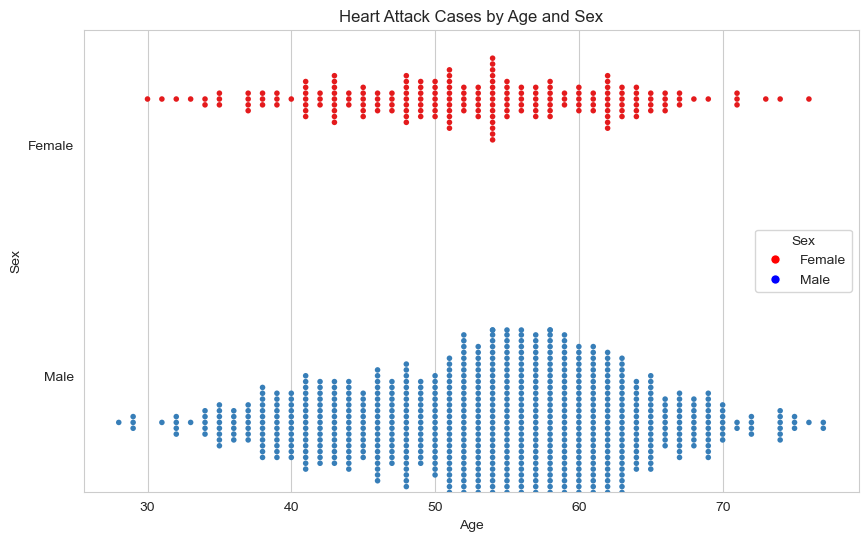

In [11]:
from matplotlib.lines import Line2D
plt.figure(figsize=(10, 6))
sns.swarmplot(x='age', y='sex', data=df, orient='h', palette='Set1', hue='sex', dodge=True, size=4)  # Adjust `size` as needed
plt.title('Heart Attack Cases by Age and Sex')
plt.xlabel('Age')
plt.ylabel('Sex')
plt.yticks(ticks=[0, 1], labels=['Female', 'Male'])
plt.legend(title='Sex', labels=['Female', 'Male'])
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=7, label='Female'),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=7, label='Male')]  # Adjust as needed
plt.legend(handles=legend_handles, title='Sex')

plt.show()

There seem to be different age peaks for men and women.  I'll print the average, median, and mode ages for each.

In [12]:
average_ages = df.groupby('sex')['age'].mean()

average_ages.index = average_ages.index.map({0: 'Female', 1: 'Male'})

print(average_ages)

sex
Female    52.474227
Male      53.787879
Name: age, dtype: float64


In [14]:
df['sex_label'] = df['sex'].map({0: 'Female', 1: 'Male'})

median_ages = df.groupby('sex_label')['age'].median()

modes_ages = df.groupby('sex_label')['age'].agg(lambda x: x.mode().tolist())

statistics_df = pd.DataFrame({'Median Age': median_ages, 'Mode Age(s)': modes_ages})

print(statistics_df)

           Median Age Mode Age(s)
sex_label                        
Female           53.0        [54]
Male             55.0    [54, 58]


As the swarmplot shows, the average age for male heart attacks is slightly higher than those for women; although the median is the same and the modes are roughly equivalent.  Now I'm curious about the columns of our data that are not numbers.  To examine them, I'll convert the labels to values, compute, then turn them back into strings.  Let's start with the 'exang' column, which looks at whether patients have exercise-induced angina (chest pain).

Percentage of entries in 'exang' column:
exang
False    61.040462
True     38.959538
Name: proportion, dtype: float64


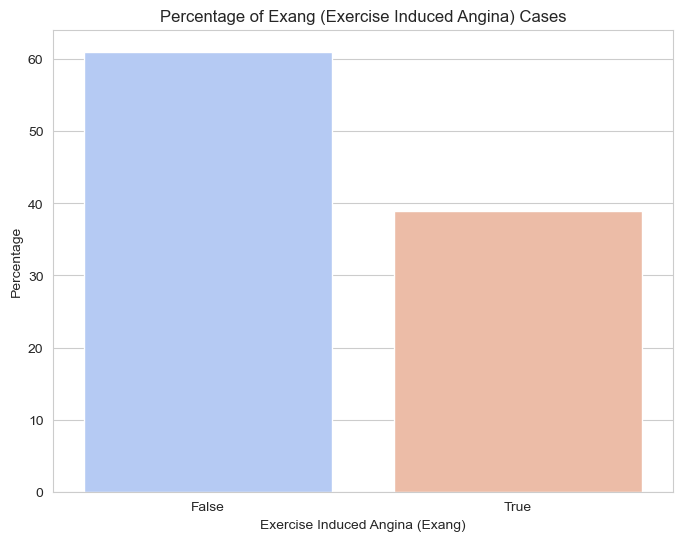

In [16]:
exang_percentages = df['exang'].value_counts(normalize=True) * 100

print("Percentage of entries in 'exang' column:")
print(exang_percentages)

exang_percentages = df['exang'].value_counts(normalize=True) * 100

exang_df = exang_percentages.reset_index()
exang_df.columns = ['Exang', 'Percentage']

plt.figure(figsize=(8, 6))
sns.barplot(x='Exang', y='Percentage', data=exang_df, palette='coolwarm')
plt.title('Percentage of Exang (Exercise Induced Angina) Cases')
plt.xlabel('Exercise Induced Angina (Exang)')
plt.ylabel('Percentage')

plt.show()

That is surprising to me, since I would have thought that the majority of patients with heart attacks have exercise induced chest pain.  Now let's look at the most common type of chest pain (typical angina, atypical angina, non-anginal, or asymptomatic).


0     typical angina
1       asymptomatic
2       asymptomatic
3        non-anginal
4    atypical angina
Name: cp, dtype: object
['typical angina' 'asymptomatic' 'non-anginal' 'atypical angina']


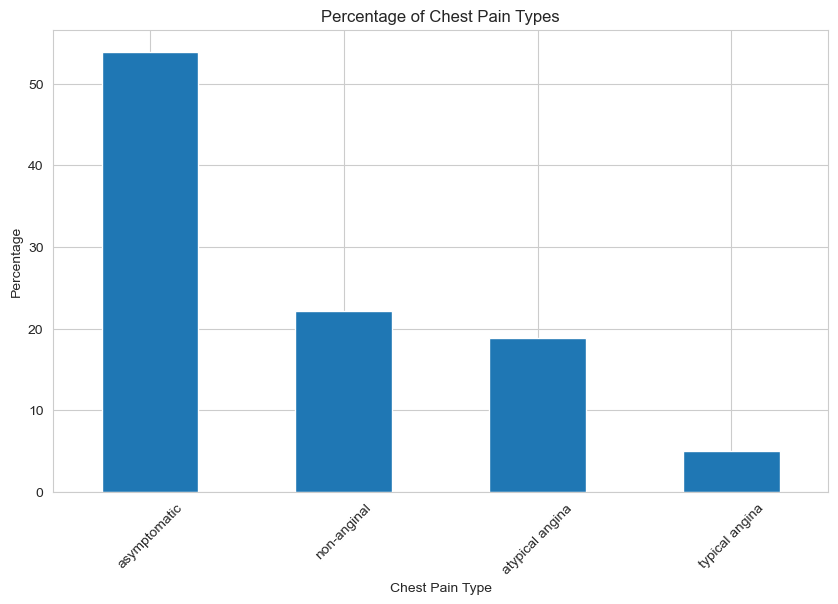

In [27]:
df_clean = df.dropna(subset=['cp'])

print(df_clean['cp'].head())
print(df_clean['cp'].unique())

cp_counts = df['cp'].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 6))
cp_counts.plot(kind='bar')
plt.title('Percentage of Chest Pain Types')
plt.xlabel('Chest Pain Type')
plt.ylabel('Percentage')
plt.xticks(rotation=45)  # Rotate labels to make them readable
plt.show()

This matches up with what we observed looking at the exercise-induced angina column - the majority of heart attack patients do not experience heart pain.  But what about patients' resting heart rate?  Is there a correlation between low or high heart rates and heart attacks?

0    lv hypertrophy
1    lv hypertrophy
2    lv hypertrophy
3            normal
4    lv hypertrophy
Name: restecg, dtype: object
['lv hypertrophy' 'normal' 'st-t abnormality']


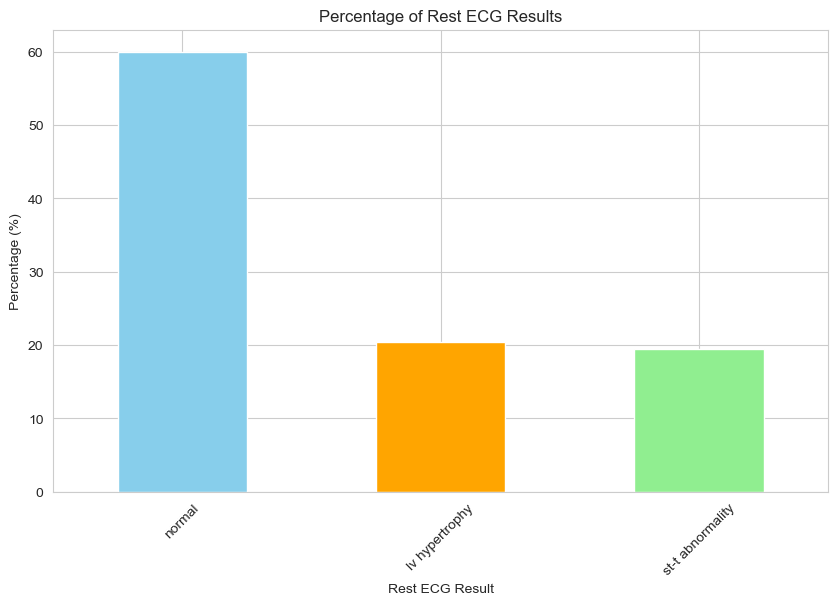

In [29]:
df_clean = df.dropna(subset=['restecg'])

print(df_clean['restecg'].head())
print(df_clean['restecg'].unique())

restecg_percentages = df['restecg'].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 6))
restecg_percentages.plot(kind='bar', color=['skyblue', 'orange', 'lightgreen'])
plt.title('Percentage of Rest ECG Results')
plt.xlabel('Rest ECG Result')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)  # Rotate labels to make them readable
plt.show()

After conducting this exploratory data analysis, I have found that age is not a reliable predictor in heart attacks, that the average age for heart attacks in men is, on average, slightly higher than those for women, and that exercise-induced angina, chest pain, and high resting ECG are by no means necessary prerequisites for a heart attack.  In a future project, I could apply these insights by trying to make a predictive model that anticipates whether an individual has a high risk for a heart attack.  Before making such a model, however, I would want to have a better understanding of the current state of heart disease research, more thorough data cleaning, and a larger data set.